In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from rl_algos.ppo_clipped_normal import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

## Bandwidth in Transformer and Bandwidth in Reward Function

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 0.0
smoothness_baseline_scale = 1.0
apply_smoothing = False
bandwidth = 50.0
freq_relative_cutoff = 0.1
bandwidth_coeff = 100.0
apply_bandwidth_constraint = True
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "apply_smoothing": apply_smoothing,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "apply_bandwidth_constraint": apply_bandwidth_constraint,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight
}

num_envs = 256
num_updates = 4000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 128,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [4]:
single_train = jit(PPO_make_train(config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates
global update: 100
reward: -343.91419783545354
max pF: 2.5545808710359466
max photon: 38.21721263974905
photon time: 0.6004895114105356
smoothness: 0.00047351512335580754
bandwidth: 228.5020661157025
global update: 200
reward: -61.33299349996779
max pF: 2.567194209086015
max photon: 50.67298837006092
photon time: 0.554724779172174
smoothness: 0.0005144775618983663
bandwidth: 74.34917355371901
global update: 300
reward: -17.599715801352176
max pF: 2.5628511270111516
max photon: 43.76107983291149
photon time: 0.6927046613446548
smoothness: 0.000563101667904699
bandwidth: 59.891528925619824
global update: 400
reward: -28.35419917602622
max pF: 2.5638063569131084
max photon: 43.016721829771996
photon time: 0.6627482950003754
smoothness: 0.0005934286350680015
bandwidth: 66.849173553719
global update: 500
reward: -19.657122701165513
max pF: 2.563584984736047
max photon: 43.52449396252632
photon time: 0.71771988887373
smoothness: 0.0004668171935133342
bandwidth:

In [4]:
from utils import photon_env_dicts

env = photon_env_dicts()[config["ENV_NAME"]](**config["ENV_PARAMS"])

In [6]:
base_smoothness = env.baseline_smoothness

print(base_smoothness)

0.0002373512739794517


In [8]:
from jax.numpy.fft import fft, fftfreq, ifft, fftshift, ifftshift

dummy_waveform = env.dummy_a3r_waveform(t2=0.1)
env.kernel = env.default_params.gauss_kernel
smooth_waveform = env.drive_smoother(dummy_waveform)
smooth_waveform = env.drive_smoother(smooth_waveform)
smooth_waveform = env.drive_smoother(smooth_waveform)
smooth_waveform = env.drive_smoother(smooth_waveform)
env.kernel = env.default_params.dirac_delta_kernel
env.freq_relative_cutoff = 0.02

dummy_bandwidth = env.calculate_bandwidth(smooth_waveform)

fft_freqs = fftfreq(env.num_actions, env.ts_action[1] - env.ts_action[0])
fft_dummy = fft(smooth_waveform)
mag_fft_dummy = jnp.abs(fft_dummy)

fft_freqs_shift = fftshift(fft_freqs)
mag_fft_dummy_shift = fftshift(mag_fft_dummy)
bandwidth = jnp.abs(fft_freqs_shift[jnp.where(mag_fft_dummy_shift > env.freq_relative_cutoff * jnp.max(mag_fft_dummy), size=1)[0][0]])

print(bandwidth)

print(f"Dummy Bandwidth: {dummy_bandwidth}")

fig, ax = plt.subplots(2)

ax[0].plot(dummy_waveform, label='dummy')
ax[0].plot(smooth_waveform, label='smoothed')
ax[0].legend()

ax[1].plot(fft_freqs_shift, mag_fft_dummy_shift, label='dummy')
ax[1].axhline(y=env.freq_relative_cutoff * jnp.max(mag_fft_dummy))
ax[1].set_yscale('log')
ax[1].legend()

print(mag_fft_dummy)

plt.show()

67.43801652892562
Dummy Bandwidth: 67.43801652892562


[16.97710422 37.89048094 25.62961485  8.72022056 13.94928289  4.46703792
  6.05640828  4.54266567  1.06412175  3.94293742  1.5496381   3.53714752
  1.97265406  0.79437266  0.97076766  0.99601555  0.99320463  1.28463744
  0.28448207  0.71393153  0.53037079  0.45485652  0.55926771  0.25774054
  0.46154667  0.32211493  0.33781562  0.30043565  0.26890161  0.2782067
  0.25189039  0.23871239  0.22805646  0.21742282  0.21038559  0.2019435
  0.19333423  0.18868256  0.18200013  0.17754279  0.17255201  0.1684017
  0.16480963  0.1612899   0.15830497  0.15548325  0.15301165  0.15076443
  0.148741    0.14693507  0.14532221  0.14389457  0.14263819  0.14154324
  0.14060272  0.13980894  0.13915591  0.13863924  0.1382547   0.13800006
  0.13787311  0.13787311  0.13800006  0.1382547   0.13863924  0.13915591
  0.13980894  0.14060272  0.14154324  0.14263819  0.14389457  0.14532221
  0.14693507  0.148741    0.15076443  0.15301165  0.15548325  0.15830497
  0.1612899   0.16480963  0.1684017   0.17255201  0.17

In [24]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
actions = metrics["action"]

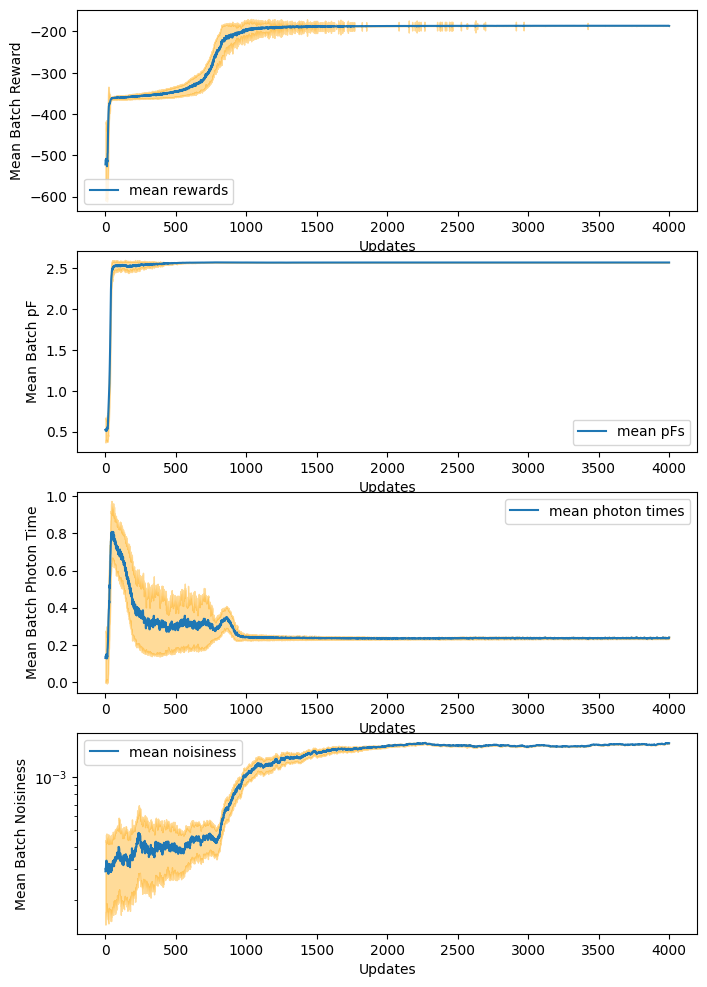

In [25]:
from utils import plot_learning

plot_learning(
    rewards=rewards,
    max_pFs=max_pFs,
    photon_times=photon_times,
    smoothnesses=smoothnesses,
)

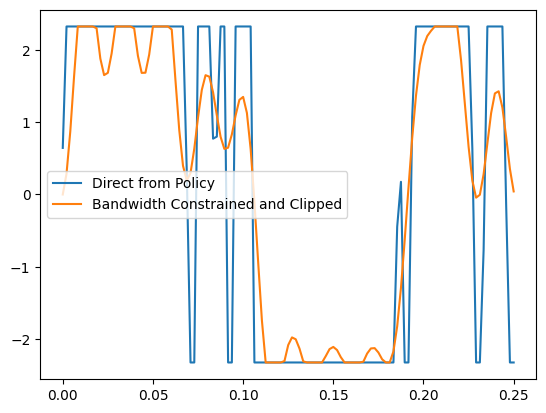

In [26]:
raw_final_action = -jnp.mean(actions, axis=1)[-1]
raw_transformed_action = env.prepare_action(raw_final_action)
env.kernel = env.default_params.gauss_kernel
smooth_final_action = env.drive_smoother(raw_transformed_action)

plt.plot(env.ts_action, raw_final_action, label='Direct from Policy')
plt.plot(env.ts_action, raw_transformed_action / env.a0, label='Bandwidth Constrained and Clipped')
# plt.plot(env.ts_action, smooth_final_action, label='Smoothed')
plt.legend()
plt.show()

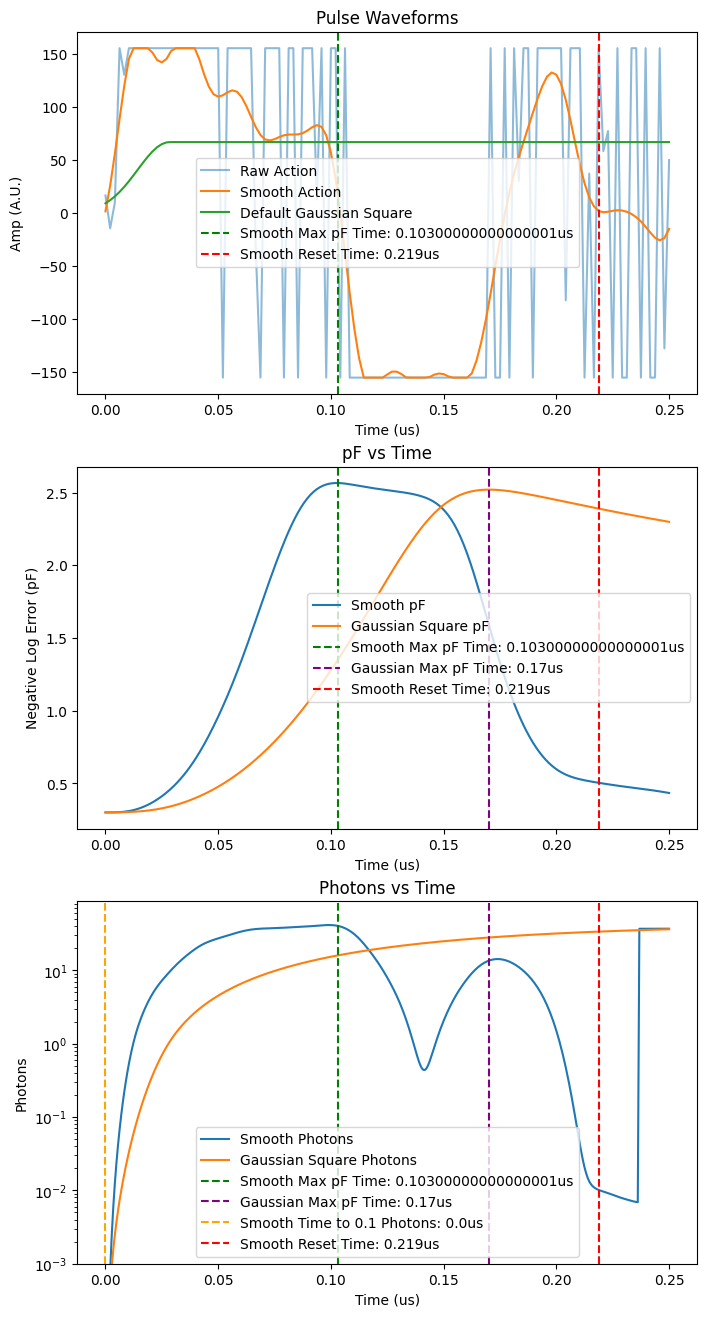

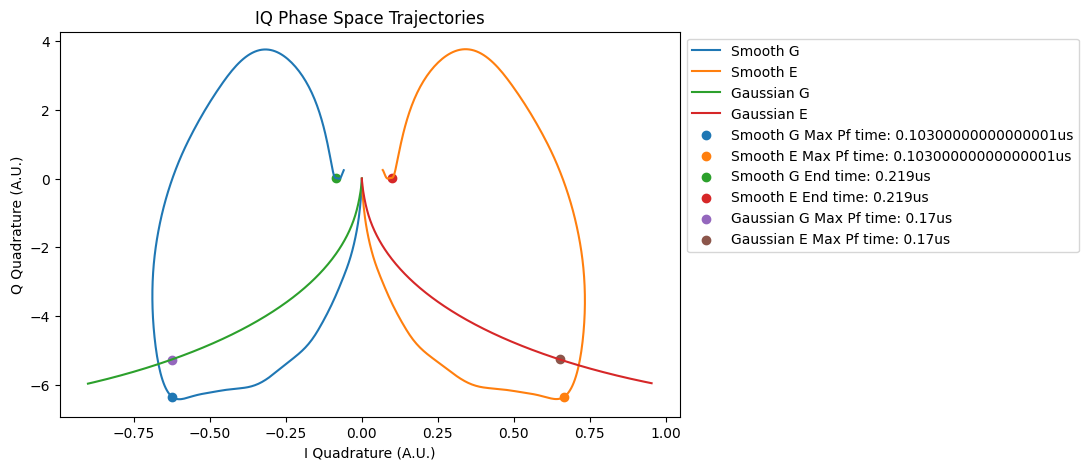

In [13]:
env.rollout_action(raw_final_action, photon_log_scale=True)

## Bandwidth and Smoothing in Transformer, and Smoothing in Reward

In [14]:
config_2 = config
config_2["ENV_PARAMS"]["apply_smoothing"] = True

config_2

{'LR': 0.0003,
 'NUM_ENVS': 256,
 'NUM_STEPS': 1,
 'NUM_UPDATES': 4000,
 'UPDATE_EPOCHS': 4,
 'NUM_MINIBATCHES': 4,
 'CLIP_EPS': 0.2,
 'VALUE_CLIP_EPS': 0.2,
 'ENT_COEF': 0.0,
 'VF_COEF': 0.5,
 'MAX_GRAD_NORM': 0.5,
 'ACTIVATION': 'relu6',
 'LAYER_SIZE': 64,
 'ENV_NAME': 'single_langevin_env',
 'ENV_PARAMS': {'kappa': 20.0,
  'chi': 4.084070449666731,
  'kerr': 0.002,
  'time_coeff': 10.0,
  'snr_coeff': 10.0,
  'smoothness_coeff': 10.0,
  'smoothness_baseline_scale': 1.0,
  'apply_smoothing': True,
  'bandwidth': 50.0,
  'apply_bandwidth_constraint': True,
  'n0': 43,
  'tau_0': 0.398,
  'res_amp_scaling': 2.3255813953488373,
  'nR': 0.01,
  'snr_scale_factor': 1.9,
  'gamma_I': 0.007142857142857143,
  'photon_gamma': 0.0006666666666666666,
  'num_t1': 5.0,
  'init_fid': 0.9999,
  'photon_weight': 4.0},
 'ANNEAL_LR': False,
 'DEBUG': True,
 'DEBUG_ACTION': False,
 'PRINT_RATE': 100,
 'ACTION_PRINT_RATE': 100,
 'MINIBATCH_SIZE': 64}

In [15]:
single_train_2 = jit(PPO_make_train(config_2), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_2 = single_train_2(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates
global update: 100
reward: 13.217891609152911
max pF: 2.5019277989494446
max photon: 28.050172727555037
photon time: 0.8305780335797956
smoothness: 0.00018745488961442662
global update: 200
reward: 15.187456171638871
max pF: 2.4951874465474604
max photon: 30.47944063693285
photon time: 0.5930542134455865
smoothness: 0.00017505422788543216
global update: 300
reward: 17.82154328378982
max pF: 2.5236281522617956
max photon: 33.323456607759
photon time: 0.3405028890975287
smoothness: 0.00013999692828785395
global update: 400
reward: 18.757814320311574
max pF: 2.5404331022270403
max photon: 34.72332872450352
photon time: 0.3320117710868471
smoothness: 0.00012542469652947153
global update: 500
reward: 19.664111167931473
max pF: 2.5446302876054485
max photon: 35.4398949816823
photon time: 0.29001785660422463
smoothness: 0.00013120529348356575
global update: 600
reward: 20.346084303687142
max pF: 2.5508317922157633
max photon: 35.93721253424883
photon time: 0.288

In [16]:
# Extracting Results

metrics_2 = single_result_2["metrics"]

rewards_2 = metrics_2["reward"]
max_pFs_2 = metrics_2["max pF"]
max_photons_2 = metrics_2["max photon"]
photon_times_2 = metrics_2["photon time"]
smoothnesses_2 = metrics_2["smoothness"]
actions_2 = metrics_2["action"]

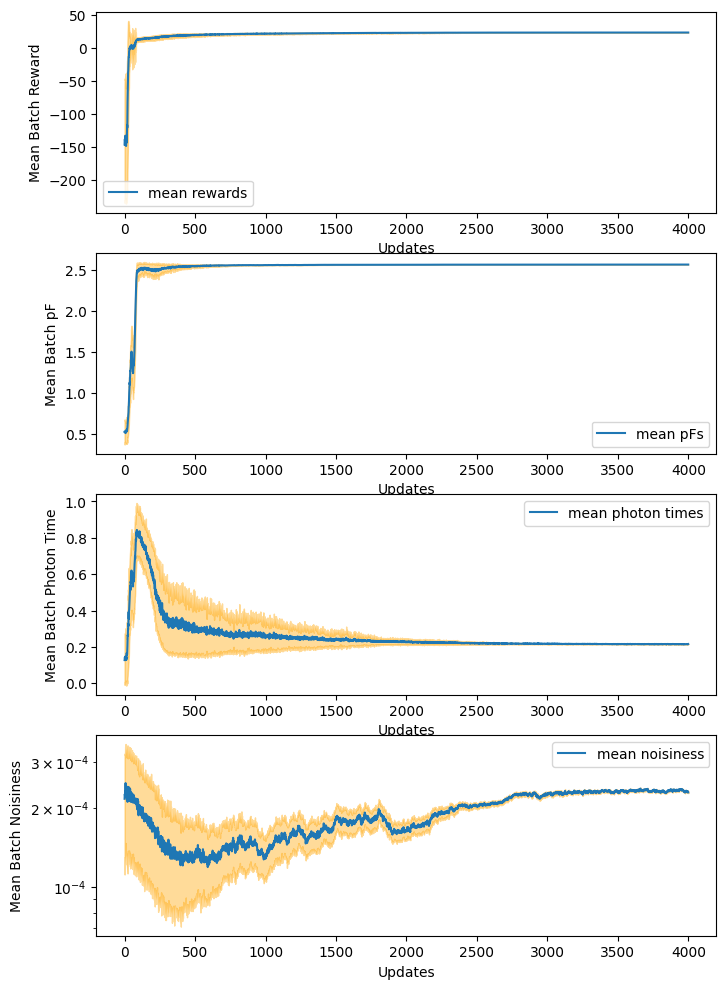

In [17]:
plot_learning(
    rewards=rewards_2,
    max_pFs=max_pFs_2,
    photon_times=photon_times_2,
    smoothnesses=smoothnesses_2,
)

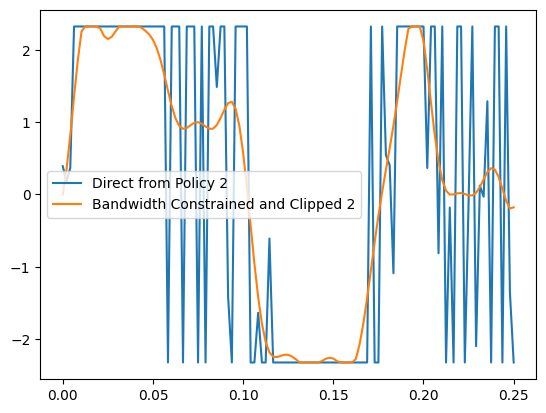

In [18]:
raw_final_action_2 = -jnp.mean(actions_2, axis=1)[-1]
raw_transformed_action_2 = env.prepare_action(raw_final_action_2)
env.kernel = env.default_params.gauss_kernel
smooth_final_action_2 = env.drive_smoother(raw_transformed_action_2)

plt.plot(env.ts_action, raw_final_action_2, label='Direct from Policy 2')
plt.plot(env.ts_action, raw_transformed_action_2 / env.a0, label='Bandwidth Constrained and Clipped 2')
# plt.plot(env.ts_action, smooth_final_action, label='Smoothed')
plt.legend()
plt.show()